# RLDatix Assignment

This is a notebook for the RL Datix assignment, written as I'm going through the task.

In [1]:
#Note this is to remove inconsequential warnings - usually from pandas version updates.
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import string

import datetime
import os

#import sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, log_loss, classification_report, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

import lightgbm as lgb

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

The first task is to read in the data

In [2]:
basepath = 'F:\Kaggle'
df_raw = pd.read_csv(os.path.join(basepath, 'Assignment_Data.csv'))

### Task 1 - Simple EDA

I always like to have a look at the shape and the raw data to get a feel for what I'm working with, and see any categorical variables and such.

In [3]:
df_raw.shape

(200, 9)

In [4]:
df_raw.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


Looks like there's 7 main variables, with 1 target binary variable.  I will need to look at the distributions of each of the categorical and numeric variables, however it looks like discharge_note will need some further pre-processing.  

My initial thoughts are to use a simple keyword/regex search to create some binary variables using this data.

<Axes: >

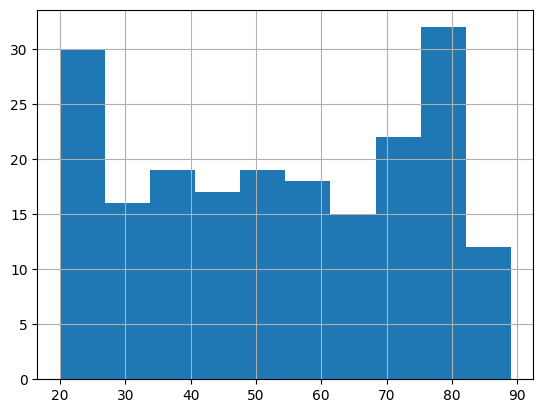

In [5]:
df_raw['age'].hist()

In [6]:
df_raw['gender'].value_counts()

gender
Female    107
Male       93
Name: count, dtype: int64

In [7]:
df_raw['diagnosis_code'].value_counts()

diagnosis_code
D001    56
D002    54
D004    53
D003    37
Name: count, dtype: int64

<Axes: >

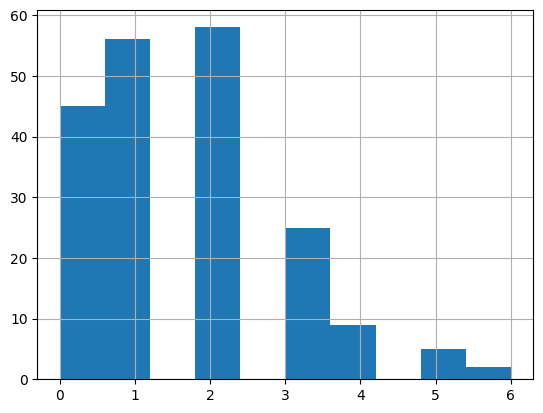

In [8]:
df_raw['num_previous_admissions'].hist()

In [9]:
df_raw['medication_type'].value_counts()

medication_type
Type B    69
Type A    67
Type C    64
Name: count, dtype: int64

<Axes: >

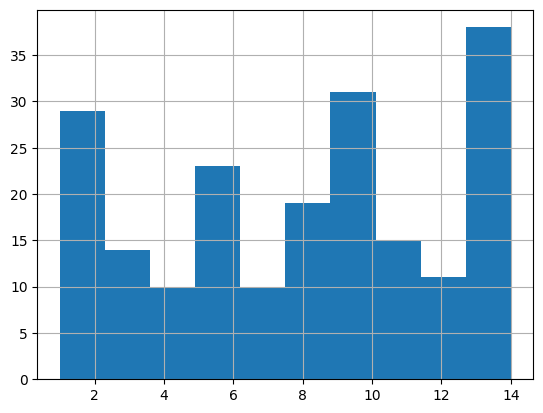

In [10]:
df_raw['length_of_stay'].hist()

In [11]:
df_raw['readmitted_30_days'].value_counts()

readmitted_30_days
0    135
1     65
Name: count, dtype: int64

So no major outliers here and most of the variables seem somewhat evenly distributed, with the exception of num_previous_admissions which looks to be a gaussian.  Diagnosis code D003 also seems under-represented.

The target is also not evenly distributed at a roughly 2:1 balance, this isn't too bad, so binary crossentropy as a loss function should be okay assuming the features are somewhat predictive.  Uniform predictions are a minor but unlikely outcome with this balance (note I'm comparing this to fraud propensity which had a 95:5 class imbalance).  Generative techniques (e.g. SMOTE) probably unnecessary and subsampling is very undesireable given the very small data size (200 samples).

In [12]:
df_raw['discharge_note'].nunique()

10

In [13]:
#Note below is commented as it produces a large text box that I read through.
list(df_raw['discharge_note'].unique())

['Good recovery trajectory. Follow-up scan scheduled next month.',
 'Stable post-surgery. Advised to avoid physical exertion.',
 'Symptoms controlled. Monitoring for relapse advised.',
 'Discharge after recovery from pneumonia. No complications observed.',
 'Patient discharged in stable condition. Recommend follow-up in 2 weeks.',
 'Patient showed improvement. Prescribed antibiotics for 5 days.',
 'Blood pressure under control. Continue current medication.',
 'Patient discharged with minor discomfort. Advised rest and hydration.',
 'No further signs of infection. Resume normal diet and activity.',
 'Mild reaction to medication. Switched to alternative treatment.']

Looking at the discharge_note there's only 10 unique notes so I can probably just treat this as a categorical variable.

To be honest an LLM doesn't seem required for this task given the small scope, and ordinarily I wouldn't use one for this however I will given I am instructed to.

Next to look at some target distributions by the variables.

In [14]:
def plot_var(df,var_to_plot):
    bar_tst = df.groupby([var_to_plot,'readmitted_30_days'])['patient_id'].count().reset_index()

    g = sns.catplot(
        data=bar_tst, kind="bar",
        x=var_to_plot, y="patient_id", hue="readmitted_30_days", palette="dark", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels(var_to_plot, "Number of Patients")
    g.legend.set_title("Re-admitted")

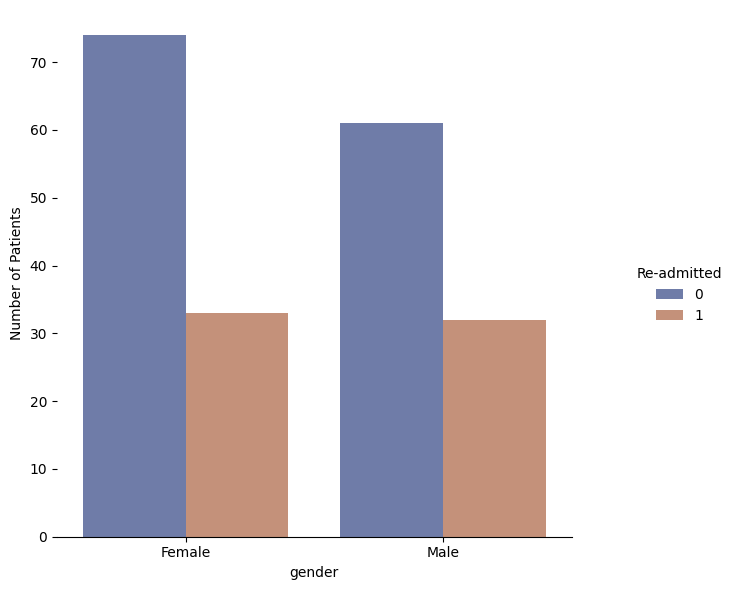

In [15]:
plot_var(df_raw, 'gender')

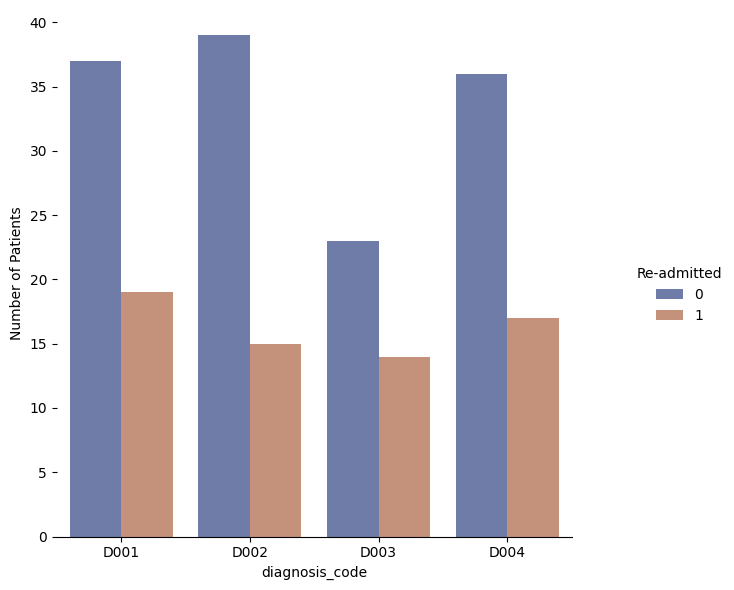

In [16]:
plot_var(df_raw, 'diagnosis_code')

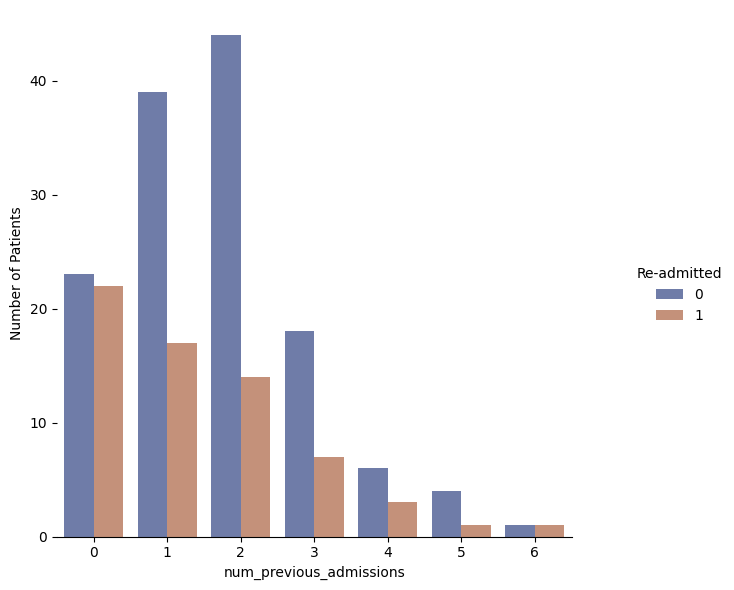

In [17]:
plot_var(df_raw, 'num_previous_admissions')

Note that 6 and 0 previous admissions are abnormally high looking at the distributions.  This is somewhat counter intuitive as I would expect this variable to increase in re-admissions as it gets higher (i.e. indicating patient complications).  An almost 50% re-admission rate for 0 stands out as odd although there's probably a medical reason (second opinion, or simply waiting to see if symptoms get worse/the problem goes away on its own).

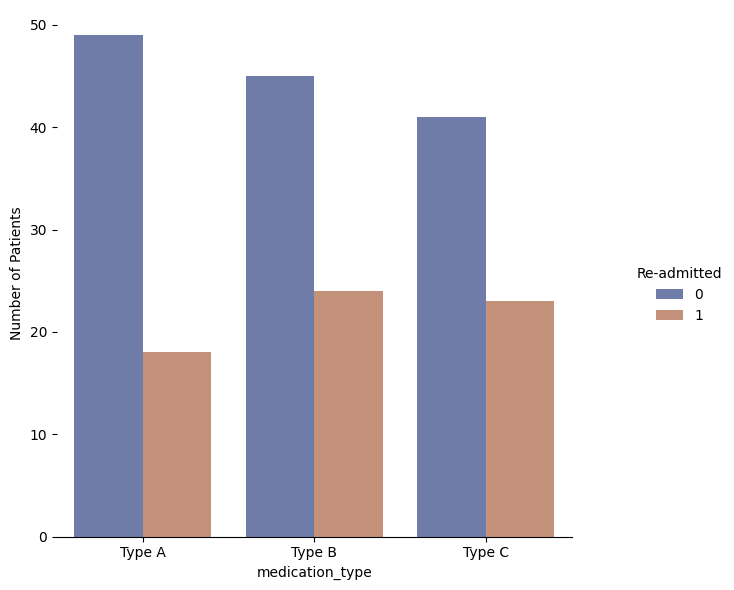

In [18]:
plot_var(df_raw, 'medication_type')

### Task 2 - Feature Engineering

Note that a bit of this was done with the discharge_note field above, but here I want to just convert all of my character fields, with the exception of discharge_note, into numeric variables so I can use them in a predictive model.

In order to encode the character fields to numeric I'll use two different kinds of encoding - target encoding and label encoding. I will probably experiment with both to see which provides better features for the model.

Target encoding may cause overfitting, which on such limited data is a significant risk, given I will be using a GBM initially as this is the model class best suited for tabular data in my experience.  However this depends if the model can fit at all.  Note as I am performing the train/test split post-encoding there is some data leakage (i.e. validation target information in the train dataset), however given the small nature of the dataset and the fact I'm only using 2 validation folds I think this is acceptable in this instance. If I were to use a 3rd validation fold I would ensure there is no data leakage.

In [19]:
#Create new copy of dataset as I will be re-mapping columns
df_vec = df_raw.copy()

In [20]:
def label_encode_col(df, col_to_map):
    val_lst = list(df[col_to_map].unique())
    map_dict = {}

    for i in range(len(val_lst)):
        map_dict[val_lst[i]] = i

    df[col_to_map] = df[col_to_map].map(map_dict)
    return df

def target_encode_col(df, col_to_map):
    val_lst = list(df[col_to_map].unique())
    map_dict = {}

    for i in range(len(val_lst)):
        map_dict[val_lst[i]] = df[df[col_to_map] == val_lst[i]]['readmitted_30_days'].mean()

    df[col_to_map] = df[col_to_map].map(map_dict)
    return df

In [21]:
#Removing these - keeping cell for testing purposes
#df_vec = label_encode_col(df_vec, 'gender')
#df_vec = label_encode_col(df_vec, 'diagnosis_code')
#df_vec = label_encode_col(df_vec, 'medication_type')
#df_vec = label_encode_col(df_vec, 'discharge_note')

In [22]:
df_vec = target_encode_col(df_vec, 'gender')
df_vec = target_encode_col(df_vec, 'diagnosis_code')
df_vec = target_encode_col(df_vec, 'medication_type')
df_vec = target_encode_col(df_vec, 'discharge_note')

Now I have the note categorized I can plot it without the axis becoming a mess.

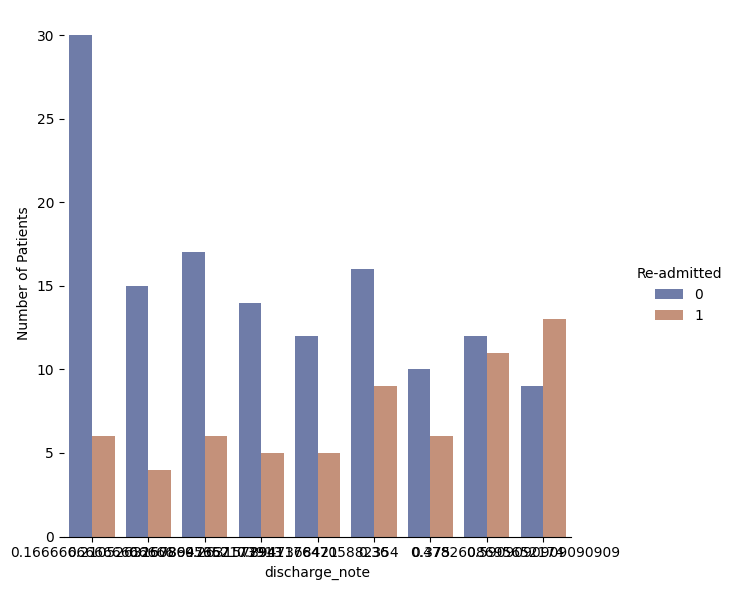

In [23]:
#Note the below only works with label encoding, otherwise becomes a mess again
plot_var(df_vec, 'discharge_note')

Now to get my feature list, target and generate a train and test dataset.  I usually do 3-fold validation at minimum however with only 200 samples I think I will have to stick to 2. 

This does mean that the resultant classifier will be overfit to this particular dataset, however with such little data getting a generalized classifier is outside of the scope of this project.  The reason the classifier will be overfit as the test set I will be using for early stopping, so by definition the resultant model will be optimised for that particular dataset.

Early stopping is an absolute requirement for using GBMs effectively in my experience because otherwise they will heavily overfit the training data, which is simply a property of boosting by definition.

In [24]:
feature_cols = ['age',
 'gender',
 'diagnosis_code',
 'num_previous_admissions',
 'medication_type',
 'length_of_stay',
 'discharge_note']

### Task 3 - Modelling

Note - no hyperparameter tuning done here because the dataset is so small its reasonable to manually tune.  When tuning hyperparameters I typically use Bayesian Optimisation with a gaussian process backend.

At time of writing I've tried a few different models - XGBoost, LightGBM both of these model classes performed extremely poorly.

I have then went on to try a couple of other models such as a simple linear regressor and a SVM and both of these models converged to uniform 0 predictions, note I didn't use any MLP as I've historically found neural networks are pretty bad at predicting tabular data and would also mean more feature engineering (standard scalers are required for numeric features) and implementing SHAP for feature importances.

For now I will leave the "best" model - LightGBM and perhaps come back when I have the LLM implemented.

Note the performance is greatly dependant upon the seed of the train_test_split due to the extremely small datasets.

In [172]:
#Generate test/train datasets
X_train, X_test, y_train, y_test = train_test_split(df_vec[feature_cols], df_vec['readmitted_30_days'], test_size=0.35,\
                                                    random_state=545)

In [173]:
lgb_mod = lgb.LGBMClassifier(objective='binary', n_estimators=300, boosting_type='gbdt', \
                             metric="auc",importance_type='gain')

In [174]:
lgb_mod.fit(X_train,y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ]
)

[LightGBM] [Info] Number of positive: 47, number of negative: 83
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 130, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.361538 -> initscore=-0.568693
[LightGBM] [Info] Start training from score -0.568693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

LGBMClassifier(importance_type='gain', metric='auc', n_estimators=300,
               objective='binary')

In [175]:
train_preds = lgb_mod.predict(X_train)

In [177]:
#lgb feat imp
imp_df = pd.DataFrame(sorted(zip(lgb_mod.booster_.feature_importance(importance_type='gain'), X_train.columns)), columns=['Value', 'Feature'])
imp_df.sort_values('Value', ascending=False, inplace=True)

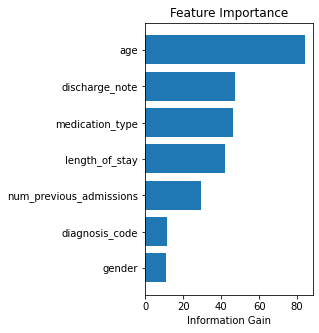

In [178]:
fig, ax  = plt.subplots(figsize=(3, 5))

ax.barh(imp_df['Feature'], imp_df['Value'])
ax.set_yticklabels(imp_df['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Information Gain')
ax.set_title('Feature Importance')
plt.show()

Note the above indicates that age was by far the most important variable with gender and diagnosis code being the least important.  Interestingly discharge_note was also influential, I suspect this was due to the target encoding.

In [179]:
train_preds = lgb_mod.predict(X_train)
test_preds = lgb_mod.predict(X_test)

train_preds_proba = lgb_mod.predict_proba(X_train)
test_preds_proba = lgb_mod.predict_proba(X_test)

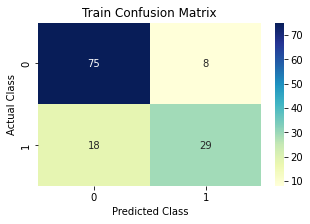

In [180]:
fig, ax  = plt.subplots(figsize=(5, 3))

sns.heatmap(confusion_matrix(y_train, train_preds), cmap='YlGnBu', fmt='g', annot=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Train Confusion Matrix')

plt.show()

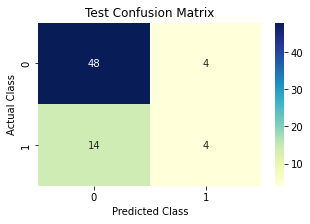

In [181]:
fig, ax  = plt.subplots(figsize=(5, 3))

sns.heatmap(confusion_matrix(y_test, test_preds), cmap='YlGnBu', fmt='g', annot=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Test Confusion Matrix')

plt.show()

In [182]:
print('Train Classification Report')
print(classification_report(y_train, train_preds))

Train Classification Report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        83
           1       0.78      0.62      0.69        47

    accuracy                           0.80       130
   macro avg       0.80      0.76      0.77       130
weighted avg       0.80      0.80      0.79       130



In [183]:
print('Test Classification Report')
print(classification_report(y_test, test_preds))

Test Classification Report
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        52
           1       0.50      0.22      0.31        18

    accuracy                           0.74        70
   macro avg       0.64      0.57      0.57        70
weighted avg       0.70      0.74      0.70        70



In [184]:
#Bringing in some ROC/PR curve tools I built earlier - note I would usually have this kind of thing in a .py file and import
#However I wanted everything in this exercise to be a self-contained notebook
def plot_roc_curve(y_true, y_score, y_label, title):
    plt.figure(figsize=(15, 10))
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    
    plt.plot(fpr, tpr, lw=2, label ='ROC curve %s (area=%0.2f)' % (y_label, auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
    plt.show()

def plot_pr_curve(y_true, y_score, y_label, title):
    plt.figure(figsize=(15, 10))
    
    prec, recall, thresholds = precision_recall_curve(y_true, y_score, pos_label=1)
    
    plt.plot(recall, prec, lw=2, label ='Average Precision %s (average_precision=%0.2f)' % (y_label, average_precision_score(y_true, y_score)))
    plt.plot([0, 0], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower right')
    
    plt.show()
    

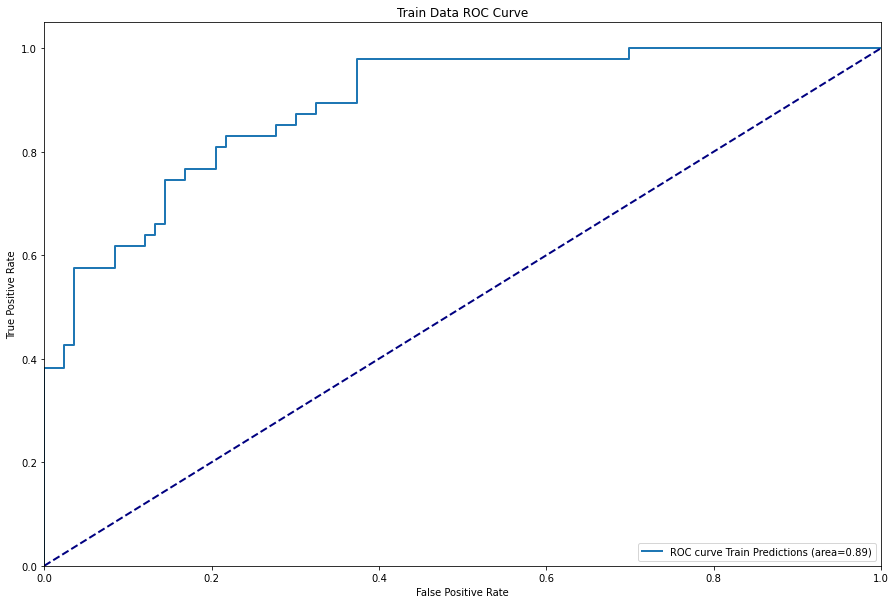

In [185]:
plot_roc_curve(y_train, train_preds_proba[:,1], 'Train Predictions', 'Train Data ROC Curve')

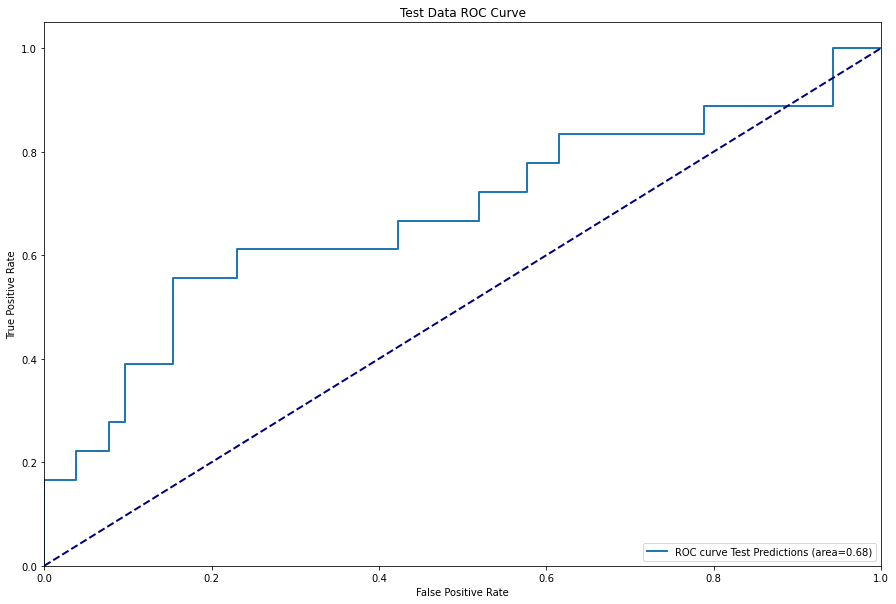

In [186]:
plot_roc_curve(y_test, test_preds_proba[:, 1], 'Test Predictions', 'Test Data ROC Curve')

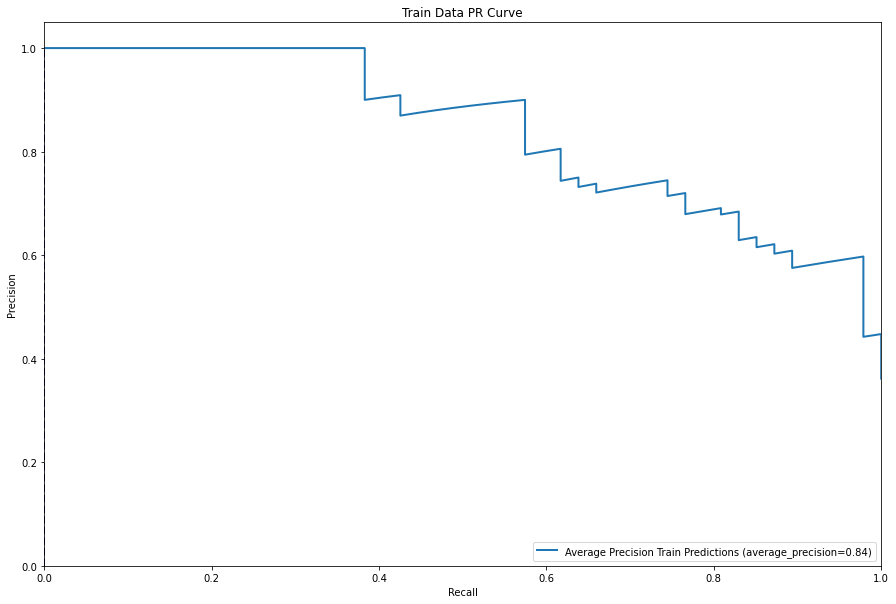

In [187]:
plot_pr_curve(y_train, train_preds_proba[:,1], 'Train Predictions', 'Train Data PR Curve')

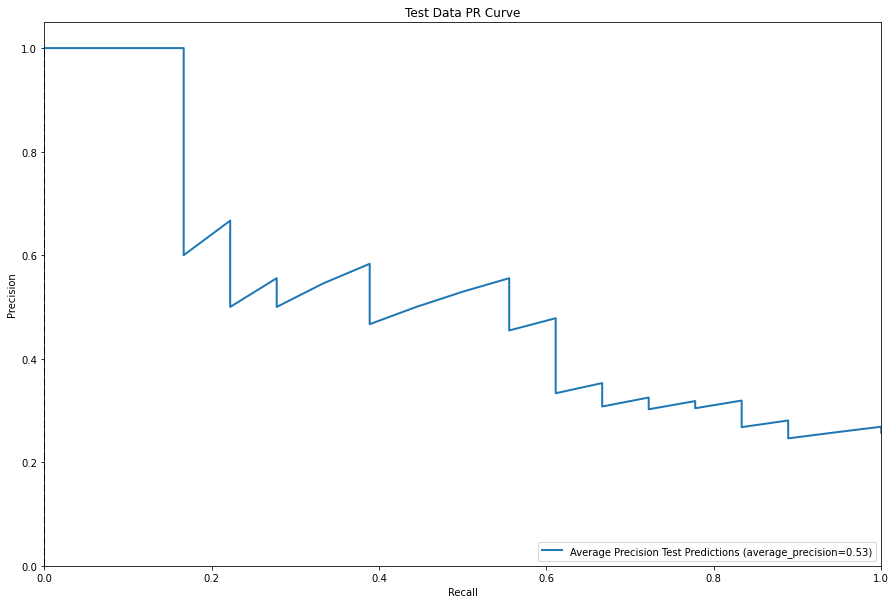

In [188]:
plot_pr_curve(y_test, test_preds_proba[:, 1], 'Test Predictions', 'Test Data PR Curve')

Note that the above charts indicate the model is heavily overfit on the train data (not unexpected) but has atrocious out of sample performance, in fact the ROC curve being 0.68 indicates the performance is slightly better than randomly guessing.

Having tried a few different parameters, I think that getting good out of sample performance isn't really possible without significantly more data.

The above is about the best I was able to obtain for the time being, future areas I would explore are things like polynomial features and adding bayesian optimisation for hyperparameter tuning.  However if this was a real world project I would insist upon getting more data as I feel that getting any kind of generalizable results are impossible without significantly more data.

Also it is worth noting that the target encoding for the discharge_notes is a significant data leakage risk for productionalization because there are only 10 distinct values therefore I chose to treat this variable as a categorical variable, however given the low volume of data each unique value represents 5% of the overall data.  This is an issue because I used a 35/65 train test split, therefore the test set very likely has entire categories that do not appear in the train data, therefore their encoding is essentially voided due to target leakage.  However, due to the poor model performance due to lack of data I would argue this is an acceptable risk as the benefits outweight the issues if we assume that this can be rectified with more data, assuming the notes fit into the currently defined categories.

If not however then I would use my initial idea of creating features based on keywords, or of course using an LLM for named entity extraction as below.

### Task 4 - Named Entity Extraction

For this I'm going to first do some simple data preperation and manually label the data as looking online the prebuilt NER models are for identifying people or geographical locations or organizations as opposed to medical symptoms or medications.

In [299]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertForTokenClassification, BertTokenizerFast
from transformers import pipeline

import torch
from torch.utils.data import Dataset, DataLoader

In [263]:
#First convert everything to lower case and remove punctuation
l_notes = []
l_notes_splt = []
for n in uniq_notes:
    low = n.lower()
    low = low.translate(str.maketrans('', '', string.punctuation))
    l_notes.append(low)
    splt = low.split()
    l_notes_splt.append(splt)

In [243]:
new_med_dict = {
    'O' : 'Outside of a named entity',
    'TRT' : 'Treatment',
    'DGN' : 'Diagnosis',
    'SYM' : 'Symptom',
    'FOL' : 'Follow-up Action',
    'MED' : 'Medication'
}

In [244]:
#Create lookup dictionaries to convert to encoding for use in model
labels_to_ids = {}
ids_to_labels = {}

lab_lst = list(new_med_dict.keys())
for i in range(len(lab_lst)):
    labels_to_ids[lab_lst[i]] = i
    ids_to_labels[i] = lab_lst[i]

In [245]:
labels_to_ids

{'O': 0, 'TRT': 1, 'DGN': 2, 'SYM': 3, 'FOL': 4, 'MED': 5}

In [246]:
ids_to_labels

{0: 'O', 1: 'TRT', 2: 'DGN', 3: 'SYM', 4: 'FOL', 5: 'MED'}

In [247]:
#Note I used this cell to cycle through the notes to get the inital ideas and then fixed them later
#l_notes[9]

In [476]:
#Manually labelling data
label0 = ['O', 'O', 'O', 'O', 'FOL', 'FOL','FOL', 'O', 'O', 'O'] 
label1 = ['O', 'O', 'O', 'TRT', 'TRT', 'O','O', 'FOL', 'FOL', 'FOL', 'FOL', 'FOL']
label2 = ['O','SYM', 'DGN','FOL', 'O', 'O','O']
label3 = ['O', 'O', 'O', 'DGN', 'O', 'SYM','O', 'O', 'O']
label4 = ['O', 'O', 'O', 'O', 'DGN', 'O','O', 'FOL', 'FOL','FOL', 'FOL', 'FOL']
label5 = ['O', 'O', 'O', 'DGN', 'O', 'MED','O', 'FOL', 'FOL']
label6 = ['O', 'O', 'O', 'O', 'O', 'FOL','O', 'MED']
label7 = ['O', 'O', 'O', 'O', 'O', 'SYM','O', 'FOL', 'O', 'FOL', 'FOL']
label8 = ['O', 'O', 'O', 'O', 'O', 'SYM','O', 'O','FOL','O', 'FOL']
label9 = ['O', 'O', 'SYM', 'O', 'MED', 'O','O', 'MED', 'O']


label_lst = [label0, label1, label2, label3, label4, label5, label6, label7, label8, label9]

In [477]:
#Convert labels to numeric
label_lst_num = []

for lst in label_lst:
    append_lst = []
    for lab in lst:
        append_lst.append(labels_to_ids[lab])

    label_lst_num.append(append_lst)

In [478]:
#Import tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Note I am manually labelling the data here as there's only a small amount so its not too bad.  In the real world I would still manually label a subset of the data but only a small fraction,  I would fine tune periodically to see if the model is somewhat performative and iteratively proceed as to minimize the time spent manually labelling data.  Also the labelling here is done purely on my own judgement, I would definitely consult a medical professional to get their opinions on the labels before using them in a live system.

In an ideal world I would simply have the data pre-labelled for me, or use some kind of medical dictionary to do keyword lookups and such.

In [479]:
#Convert to pytorch dataset for use in training - just modified some code I found online for this
class dataset(Dataset):
  def __init__(self,note_lst, lab_lst , tokenizer, max_len=16):
        self.len = len(note_lst)
        self.data = note_lst
        self.labels = lab_lst
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        sentence = self.data[index]
        sentance_label = self.labels[index]

      
        #Encode sentance with tokenizer
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=False, 
                             max_length=self.max_len)

        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        for i in range(len(encoded_labels)):
            if i < len(sentance_label):
                if sentance_label[i] == 0:
                    encoded_labels[i] == -100
                else :
                    encoded_labels[i] = sentance_label[i]

        #Convert to pytorch tensor
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [480]:
training_set = dataset(l_notes,label_lst_num, tokenizer)

In [489]:
#Use this to cycle through all the data to check the labels are aligned correctly
id_to_check = 0

In [490]:
#Look at whole input data
training_set.__getitem__(id_to_check)

{'input_ids': tensor([  101,  2204,  7233, 22793,  3582,  6279, 13594,  5115,  2279,  3204,
           102,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
 'offset_mapping': tensor([[ 0,  0],
         [ 0,  4],
         [ 5, 13],
         [14, 24],
         [25, 31],
         [31, 33],
         [34, 38],
         [39, 48],
         [49, 53],
         [54, 59],
         [ 0,  0],
         [ 0,  0],
         [ 0,  0],
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]]),
 'labels': tensor([-100, -100, -100, -100,    4,    4,    4, -100, -100, -100, -100, -100,
         -100, -100, -100, -100])}

In [491]:
#Some additional verification for debugging - I used this to check all the dimensionality was consistent
#training_set.__getitem__(id_to_check)['attention_mask'].shape

torch.Size([16])

In [492]:
#Bert decided to split up words a whole bunch so going and manually fixing the labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[id_to_check]["input_ids"]), training_set[id_to_check]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
good        -100
recovery    -100
trajectory  -100
follow      4
##up        4
scan        4
scheduled   -100
next        -100
month       -100
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100


In [580]:
#Just guesstimated learning rate here, typically I use between 1e-3 and 1e-6 for NNs depending on model
#Given this is an LLM fine tune I'm starting small as its not starting from a random state
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [581]:
training_loader = DataLoader(training_set, batch_size=2)

In [582]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [583]:
#Grabbing training function I found online for training a NER model - Note I did have to modify this a bit to get it to work
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        ids = batch['input_ids']
        mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        
        tr_logits = outputs['logits']
        loss = outputs['loss']
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=10
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")

In [584]:
for epoch in range(200):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss epoch: 1.818818712234497
Training epoch: 2
Training loss epoch: 1.873989748954773
Training epoch: 3
Training loss epoch: 1.8796255826950072
Training epoch: 4
Training loss epoch: 1.8743985652923585
Training epoch: 5
Training loss epoch: 1.890501618385315
Training epoch: 6
Training loss epoch: 1.849332904815674
Training epoch: 7
Training loss epoch: 1.8125404596328736
Training epoch: 8
Training loss epoch: 1.854638409614563
Training epoch: 9
Training loss epoch: 1.8824555635452271
Training epoch: 10
Training loss epoch: 1.9031834840774535
Training epoch: 11
Training loss epoch: 1.8747788667678833
Training epoch: 12
Training loss epoch: 1.933925724029541
Training epoch: 13
Training loss epoch: 1.8251541137695313
Training epoch: 14
Training loss epoch: 1.86169273853302
Training epoch: 15
Training loss epoch: 1.849676775932312
Training epoch: 16
Training loss epoch: 1.876552414894104
Training epoch: 17
Training loss epoch: 1.816976046562195
Training epoch: 1

Now to prove the concept I will just run a simple example implementation

In [585]:
df_raw['discharge_note_clean'] = df_raw['discharge_note'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

In [586]:
#Convert the model into a pipeline for ease of use
ner_transformer = pipeline("ner", model=model, tokenizer=tokenizer)

Device set to use cpu


In [596]:
idx_to_output = 6

input_str = df_raw['discharge_note_clean'][idx_to_output]
output_lst = ner_transformer(input_str)

In [597]:
output_labels = []

for out in output_lst:
    ent = out['entity']
    ent_int = int(ent[-1])
    end_lab = ids_to_labels[ent_int]
    output_labels.append(end_lab)

In [598]:
print(input_str)
print(output_labels)

discharge after recovery from pneumonia no complications observed
['O', 'TRT', 'DGN', 'SYM', 'O', 'MED', 'MED', 'SYM']


To continue using the model outputs you have some options, either generate additional features from these for the classification model or use them to generate a quick patient summary for any doctor who next encounters this patient.

However, It appears that once again the model is struggling to train, likely because of the absolutely tiny text corpus, in this instance I would 100% use a simple regex or word lookup to generate features unless more data is given. I have tried training a couple of times with different parameters to no real success, likely because the model is so large and trying to fine tune on such a tiny vocabulary given the initial vocabulary is like trying to change the ocean current with a paddleboat.

As the base LLM was trained on a general text corpus this model would need significant fine tuning on a specific and large medical corpus to be reliable.  This is because of the risk of misinformation on the model input could have significant adverse consequences if the advice from a general LLM is used in a medical setting as the training data is likely to be incorrect.  Especially given the inputs for a lot of LLMs is typically things like reddit siterips which may well have amateurs giving opinions on medical issues which if the model outputs these potentially incorrect opinions then in a medical setting could be putting lives at risk.  This is why I would suggest significant tuning on a large medical corpus and even then to take the model outputs as nothing more than a potential guideline and not as a strict instruction.  I would absolutely insist on a random sample of outputs be vetted and verified by medical professionals before productionalizing any LLM in this setting.  

Assuming I could get more data I would fine tune the model much more, likely also add in things like learning rate attenuation and find a better way to generate targets.  I would probably ask superiors for funding when it comes to data labelling and maybe use some online service such as Amazon Mechanical Turk to get labelled data, although given the medical use I would be reviewing a lot of this work, and get a medical professional to write up guidelines for the people doing the data labelling.  Also an obvious difference would be to use a more up to date, such as DeepSeek or of course ChatGPT as the baseline model to fine tune, and do so on a cloud TPU as opposed to my personal local machine.